In [16]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


Preproccesing Functions

In [17]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new


def df_to_raw(df, sfreq=250):
    """Convert pandas DataFrame to MNE Raw object."""
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw


Define the dataset

In [18]:
# Define the column names
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
# folder_name = input("Please enter the subject name: ")

folder_name='f'
column_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

selected_columns=['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
raw = []
event=[]
bandpass=[]
denoised=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst=s_temp.iloc[:, 17]
            df_temp=s_temp.iloc[:, :8]
            raw.append(df_temp)
            event.append(inst)
            # print(df_temp.shape) # (10000, 8)
            
            #preprocess
            raw_eeg_bp = np.copy(df_temp)
            for column in range(df_temp.shape[1]):
                raw_eeg_bp[:, column] = butter_bandpass_filter(raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            bandpass.append(raw_eeg_bp) 
            
            eeg_df_denoised = preprocess(pd.DataFrame(raw_eeg_bp, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))    
            denoised.append(eeg_df_denoised)
            
            # for i in range(8):
            #     fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
            #     axs[0].plot(df_temp.iloc[:,i])
            #     axs[0].set_title(f'Original data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[1].plot(raw_eeg_bp[:,i])
            #     axs[1].set_title(f'Filtered data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[2].plot(eeg_df_denoised.iloc[:,i])
            #     axs[2].set_title(f'Denoised data of block {file_name.replace(".csv", "")} column {i}')
            #     plt.tight_layout()  # Adjusts subplot parameters for better fit
            #     plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

# Define the column names
folder_name = 'f'
column_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']


raw = []
event = []
bandpass = []
denoised = []

if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            df_temp.columns = selected_columns
            
            raw.append(df_temp)
            event.append(inst)

            # Convert dataframe to MNE Raw object
            raw_mne = df_to_raw(df_temp, sfreq=250)  # Assuming sampling rate is 250Hz

            # Apply ICA
            ica = ICA(n_components=5, method='infomax', random_state=97, max_iter=800)
            ica.fit(raw_mne)
            
            # Assuming you will perform visual inspection later
            cleaned_mne = ica.apply(raw_mne.copy(), exclude=ica.exclude)

            # Get the cleaned data back into numpy format for band-pass filter
            cleaned_data = cleaned_mne.get_data().T * 1e6  # Back to microvolts

            # Band-pass filter on cleaned data
            for column in range(cleaned_data.shape[1]):
                cleaned_data[:, column] = butter_bandpass_filter(cleaned_data[:, column], lowcut=.4, highcut=40, fs=250)
            
            bandpass.append(cleaned_data)

            # Continue with your preprocessing
            eeg_df_denoised = preprocess(pd.DataFrame(cleaned_data, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            denoised.append(eeg_df_denoised)
            
            
            
            for i in range(8):
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
                axs[0].plot(df_temp.iloc[:,i])
                axs[0].set_title(f'Original data of block {file_name.replace(".csv", "")} column {i}')
                axs[1].plot(cleaned_data[:,i])
                axs[1].set_title(f'cleaned_data {file_name.replace(".csv", "")} column {i}')
                
                
                axs[2].plot(raw_eeg_bp[:,i])
                axs[2].set_title(f'Filtered data of block {file_name.replace(".csv", "")} column {i}')
                # axs[2].plot(eeg_df_denoised.iloc[:,i])
                # axs[2].set_title(f'Denoised data of block {file_name.replace(".csv", "")} column {i}')
                plt.tight_layout()  # Adjusts subplot parameters for better fit
                plt.show()


In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

# Define the column names
folder_name = 'f'
column_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']


raw = []
event = []
bandpass = []
cleaned = []  # This will store the ICA cleaned data
denoised = []

if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            df_temp.columns = selected_columns  # Assigning column names explicitly

            raw.append(df_temp)
            event.append(inst)

            # Apply bandpass filter
            raw_eeg_bp = np.copy(df_temp)
            for column in range(df_temp.shape[1]):
                raw_eeg_bp[:, column] = butter_bandpass_filter(raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250)
            bandpass.append(raw_eeg_bp)

            # Convert dataframe to MNE Raw object
            raw_mne = df_to_raw(pd.DataFrame(raw_eeg_bp, columns=selected_columns), sfreq=250)  # Assuming sampling rate is 250Hz

            # Apply ICA
            ica = ICA(n_components=2, method='infomax', random_state=97, max_iter=50)
            ica.fit(raw_mne)

            # Assuming you will perform visual inspection later to identify artifact components
            cleaned_mne = ica.apply(raw_mne.copy(), exclude=ica.exclude)
            cleaned_data = cleaned_mne.get_data().T  # Get the cleaned data as a numpy array
            cleaned.append(cleaned_data)
            
            eeg_df_denoised = preprocess(pd.DataFrame(cleaned_data, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            denoised.append(eeg_df_denoised)
            
            # for i in range(8):
            #     fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
            #     axs[0].plot(df_temp.iloc[:2000,i])
            #     axs[0].set_title(f'Original data of block {file_name.replace(".csv", "")} column {i}')
                
            #     axs[1].plot(raw_eeg_bp[:2000,i])
            #     axs[1].set_title(f'Filtered data of block {file_name.replace(".csv", "")} column {i}')
                
            #     axs[2].plot(cleaned_data[:2000,i])
            #     axs[2].set_title(f'cleaned_data {file_name.replace(".csv", "")} column {i}')
                
                
               
            #     # axs[2].plot(eeg_df_denoised.iloc[:,i])
            #     # axs[2].set_title(f'Denoised data of block {file_name.replace(".csv", "")} column {i}')
            #     plt.tight_layout()  # Adjusts subplot parameters for better fit
            #     plt.show()



Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    39.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 2 components
 


C:\Users\tnlab\AppData\Local\Temp\ipykernel_7360\1124383481.py:45: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_mne)


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


In [70]:
event=np.array(event).reshape(40*10000, 1)
raw=np.array(raw).reshape(40*10000, 8)   
bandpass=np.array(bandpass).reshape(40*10000, 8)   
denoised=np.array(denoised).reshape(40*10000, 8)   
pp_sig_event=np.concatenate((denoised, event), axis=1)

labels=[] 
face = [] #lable=0
scene=[]#lable=1
for i in range(len(pp_sig_event)):
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)
        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)     
             
print('event', event.shape, 'raw', raw.shape, 'bandpass', bandpass.shape, 'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)          

event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)


In [ ]:
for i in range(8):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
    axs[0].plot(denoised[:10000,i])
    axs[0].set_title(f'Original data of column {i}')
    axs[1].plot(bandpass[:,i])
    axs[1].set_title(f'Filtered data of column {i}')
    axs[2].plot(denoised[:,i])
    axs[2].set_title(f'Denoised data of column {i}')
    plt.tight_layout()  # Adjusts subplot parameters for better fit
    plt.show() 

In [71]:
face_eeg_dada=face.reshape(20,40,50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)

scene_eeg_dada=scene.reshape(20,40,50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))


(20, 50, 8)
(50, 8)
(20, 50, 8)
(50, 8) <class 'numpy.ndarray'>


In [72]:
fs=250
time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

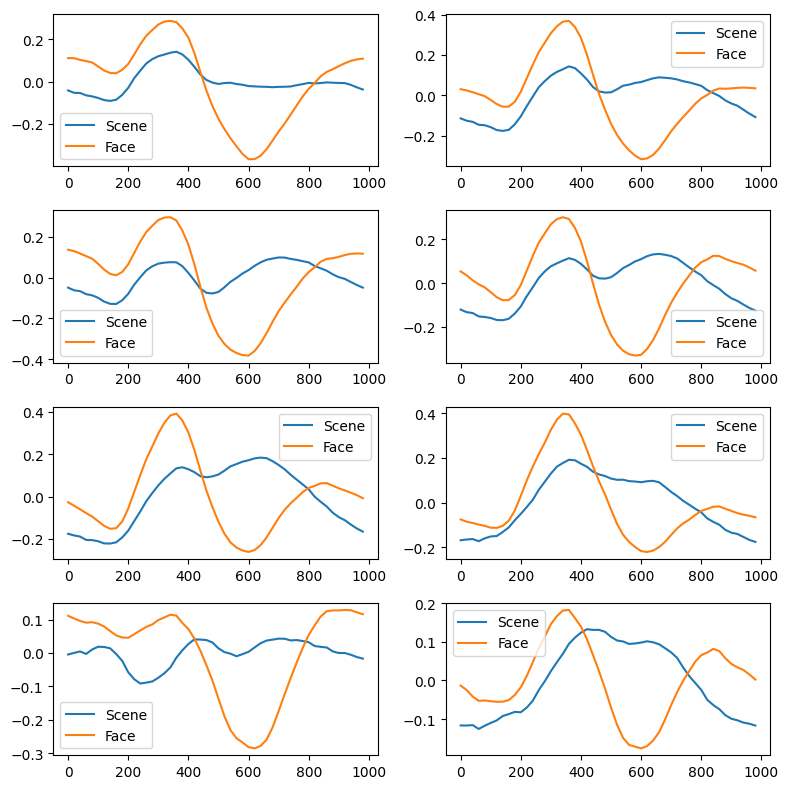

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()


ERP Feature Extraction

In [74]:
P300_window = (15, 30) 
N600_window = (30, 45)
N300_window = (15, 30)
P600_window = (30, 45)

def extract_ERP_features(epoch):
    # For face
    P300_region = epoch[P300_window[0]:P300_window[1]]
    N600_region = epoch[N600_window[0]:N600_window[1]]

    P300_amplitude = np.max(P300_region)
    P300_mean_amplitude = np.mean(P300_region)
    P300_latency = np.argmax(P300_region) + P300_window[0]

    N600_amplitude = np.min(N600_region)
    N600_mean_amplitude = np.mean(N600_region)
    N600_latency = np.argmin(N600_region) + N600_window[0]

    # For scene
    N300_region = epoch[N300_window[0]:N300_window[1]]
    P600_region = epoch[P600_window[0]:P600_window[1]]

    N300_amplitude = np.min(N300_region)
    N300_mean_amplitude = np.mean(N300_region)
    N300_latency = np.argmin(N300_region) + N300_window[0]

    P600_amplitude = np.max(P600_region)
    P600_mean_amplitude = np.mean(P600_region)
    P600_latency = np.argmax(P600_region) + P600_window[0]

    return [
        P300_amplitude, P300_mean_amplitude,
        N600_amplitude,  N600_mean_amplitude,
        N300_amplitude,  N300_mean_amplitude,
        P600_amplitude, P600_mean_amplitude
    ]


In [75]:
#event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)
X=denoised.reshape(1600, 250*8)
labels=labels.reshape(1600, 250)
Y=np.squeeze(labels[:,0])
print(X.shape, Y.shape)

(1600, 2000) (1600,)


ERP for each image

In [76]:
data_reshaped = X.reshape(1600, 8, 250)
erp_features_for_all_images = np.array([[extract_ERP_features(data_reshaped[i, j, :]) for j in range(8)] for i in range(1600)])
print(erp_features_for_all_images.shape)  # Should print (1600, 8, 6)


(1600, 8, 8)


Feature Extraction

In [77]:
import numpy as np
from scipy.signal import butter, filtfilt
from numpy import unwrap, diff, abs, angle

fs = 250  # Sampling rate

# Defining the frequency bands
frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40)
}

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


In [78]:
import numpy as np
from scipy.signal import hilbert
from numpy import angle, unwrap, diff

def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = angle(analytic_signal)
    unwrapped_phase = unwrap(instantaneous_phase)
    instantaneous_frequency = diff(unwrapped_phase) / (2.0*np.pi) * fs 
    return amplitude_envelope, instantaneous_phase, instantaneous_frequency

# Assuming dataset is your (1600, 2000) array
def extract_hilbert_features(dataset, fs):
    n_samples, n_features = dataset.shape
    n_channels = 8
    sampling_rate = int(n_features / n_channels)
    
    all_hilbert_features = []
    
    for sample in dataset:
        channel_features = []
        
        for ch in range(n_channels):
            signal = sample[ch * sampling_rate: (ch + 1) * sampling_rate]
            amplitude_envelope, instantaneous_phase, instantaneous_frequency = calculate_hilbert_features(signal, fs)
            
            # For each channel, store the averaged features
            channel_features.append([
                np.mean(amplitude_envelope),
                np.mean(instantaneous_phase),
                np.mean(instantaneous_frequency)
            ])
            
        # Append channel-wise features for each sample
        all_hilbert_features.append(channel_features)
    
    return np.array(all_hilbert_features)

fs = 250
dataset =X  # Replace with your actual dataset
hilbert_features = extract_hilbert_features(dataset, fs)
print(hilbert_features.shape)  # Should print (1600, 8, 3)


(1600, 8, 3)


In [79]:
data = X
all_features = []
# Process each EEG signal corresponding to an image
for i in range(data.shape[0]):
    eeg_signal = data[i, :].reshape(8, 250)  # reshaped to (8, 250)
    features_for_sample = []
    for channel in range(8):
        channel_signal = eeg_signal[channel, :]
        features_for_channel = []  # List to hold features for this channel
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            # Extract mean amplitude as a feature for this band
            # mean_amplitude = np.mean(np.abs(filtered_signal))
            mean_amplitude = np.mean((filtered_signal)**2)
            features_for_channel.append(mean_amplitude)
        features_for_sample.append(features_for_channel)
    all_features.append(features_for_sample) 
all_features = np.array(all_features)
print(all_features.shape)  # This should print (1600, 8, 5).


(1600, 8, 5)


In [80]:
combined_features = np.concatenate([erp_features_for_all_images,all_features], axis=2)
print(combined_features.shape)  # Should print (1600, 8, 11)


(1600, 8, 13)


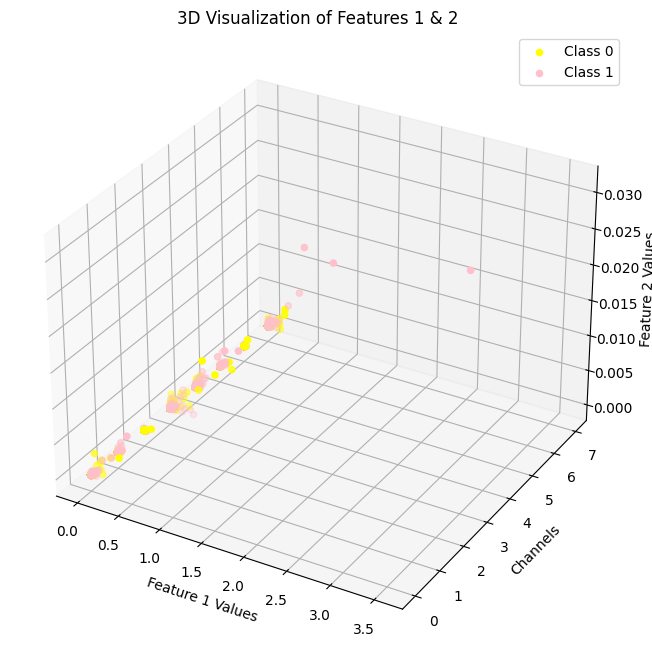

In [81]:
import math

import numpy as np
import matplotlib.pyplot as plt

def plot_features_3D(combined_features, Y, feature1_idx=0, feature2_idx=1):
    _, n_channels, _ = combined_features.shape

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # For each channel
    for channel in range(n_channels):
        
        # Extract values for the selected features and channel
        feature1_values = (combined_features[:, channel, 8])**2
        feature2_values = (combined_features[:, channel,9])**2
        
        # Plot points for the first class (assuming label 0)
        mask_class1 = (Y == 0)
        ax.scatter(feature1_values[mask_class1], [channel] * np.sum(mask_class1), feature2_values[mask_class1], 
                   color='yellow', label='Class 0' if channel == 0 else "")
        
        # Plot points for the second class (assuming label 1)
        mask_class2 = (Y == 1)
        ax.scatter(feature1_values[mask_class2], [channel] * np.sum(mask_class2), feature2_values[mask_class2], 
                   color='pink', label='Class 1' if channel == 0 else "")
    
    ax.set_xlabel(f'Feature {feature1_idx + 1} Values')
    ax.set_ylabel('Channels')
    ax.set_zlabel(f'Feature {feature2_idx + 1} Values')
    ax.set_title(f"3D Visualization of Features {feature1_idx + 1} & {feature2_idx + 1}")
    ax.legend()

    plt.show()

# Example usage:
plot_features_3D(combined_features, Y)



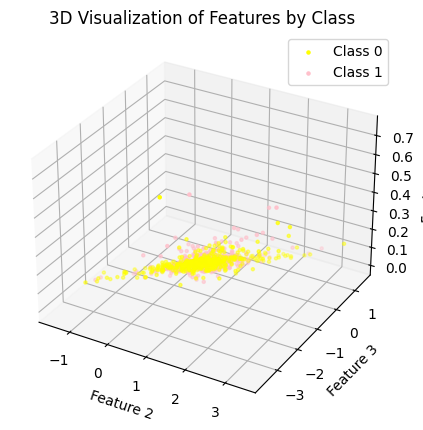

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def plot_3D_features(X, y, feature_indices=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13)):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['yellow', 'pink']

    for i, label in enumerate(np.unique(Y)):
        X_subset = combined_features[Y == label]
        
        feature1_values = X_subset[:, :, feature_indices[0]].mean(axis=1)
        feature2_values = X_subset[:, :, feature_indices[2]].mean(axis=1)
        feature3_values = X_subset[:, :, feature_indices[12]].mean(axis=1)
        
        ax.scatter(feature1_values, feature2_values, feature3_values, 
                   color=colors[i], label=f'Class {label}', s=5)
    
    ax.set_xlabel(f'Feature {feature_indices[1] + 1}')
    ax.set_ylabel(f'Feature {feature_indices[2] + 1}')
    ax.set_zlabel(f'Feature {feature_indices[3] + 1}')
    ax.set_title('3D Visualization of Features by Class')
    ax.legend()

    plt.show()

# Example usage:
plot_3D_features(combined_features, Y)


In [83]:
# all_features=all_features.reshape(1600, 8, 5)
# x=X.reshape(1600, 8, 250)
# sec_feature = np.concatenate([combined_features,x], axis=2)
# print(sec_feature.shape)
# af=sec_feature.reshape(1600, 8*267)
af=combined_features.reshape(1600, 8*13)


In [84]:
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)


# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)

# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)


print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

(1600, 104) (1600,)
(1296, 104)
(1296,) (144,)
X_train: (1296, 104) y_train: (1296,) X_test: (144, 104) y_test: (144,) X_untouch: (160, 104) y_untouch: (160,)


In [87]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.5763888888888888
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60        70
           1       0.60      0.51      0.55        74

    accuracy                           0.58       144
   macro avg       0.58      0.58      0.58       144
weighted avg       0.58      0.58      0.57       144

